## **Practical Assignment 2**

**Objective**: - Image Classification with Stanford Dogs Dataset

The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. Contents of this
dataset:
* Number of categories: 120
* Number of images: 20,580

### 1.Download Dataset

In [1]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2023-05-01 08:57:09--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  14.9MB/s    in 58s     

2023-05-01 08:58:08 (13.1 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [2]:
# Extract downloaded dataset
import tarfile

# Open the tar file in read mode
with tarfile.open('images.tar', 'r') as tar:
    # Extract all contents of the tar file
    tar.extractall()
print("Extracting images done!!")

Extracting images done!!


### Visualization

In [3]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (211, 250, 3)


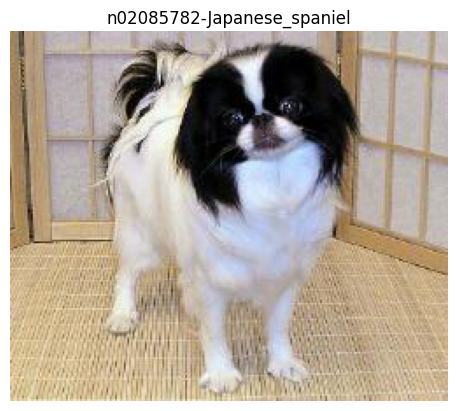

In [4]:
# View a random image from the training dataset
img = view_random_image(target_dir="Images/",
                        target_class="n02085782-Japanese_spaniel")

In [5]:
import os
import shutil
import random

# Define the paths for the original dataset and the new train/test directories
dataset_path = "/content/Images/"
train_path = "/content/dog_classification/train/"
test_path = "/content/dog_classification/test/"

# Define the percentage of images to use for testing
test_percentage = 0.3

# Loop through each subdirectory in the original dataset directory
for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)

    # Create the corresponding subdirectories in the new train/test directories
    train_subdir_path = os.path.join(train_path, subdir)
    os.makedirs(train_subdir_path, exist_ok=True)
    test_subdir_path = os.path.join(test_path, subdir)
    os.makedirs(test_subdir_path, exist_ok=True)

    # Loop through each image file in the subdirectory
    for filename in os.listdir(subdir_path):
        filepath = os.path.join(subdir_path, filename)

        # Randomly assign the image to either the train or test directory
        if random.random() < test_percentage:
            shutil.copy(filepath, os.path.join(test_subdir_path, filename))
        else:
            shutil.copy(filepath, os.path.join(train_subdir_path, filename))

In [6]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("dog_classification"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'dog_classification'.
There are 120 directories and 0 images in 'dog_classification/test'.
There are 0 directories and 63 images in 'dog_classification/test/n02110806-basenji'.
There are 0 directories and 55 images in 'dog_classification/test/n02095570-Lakeland_terrier'.
There are 0 directories and 46 images in 'dog_classification/test/n02093859-Kerry_blue_terrier'.
There are 0 directories and 51 images in 'dog_classification/test/n02086079-Pekinese'.
There are 0 directories and 39 images in 'dog_classification/test/n02090622-borzoi'.
There are 0 directories and 46 images in 'dog_classification/test/n02106030-collie'.
There are 0 directories and 62 images in 'dog_classification/test/n02096585-Boston_bull'.
There are 0 directories and 47 images in 'dog_classification/test/n02109961-Eskimo_dog'.
There are 0 directories and 36 images in 'dog_classification/test/n02100735-English_setter'.
There are 0 directories and 43 images in 'dog_classification/t

In [7]:
img.shape

(211, 250, 3)

In [8]:
img.min(), img.max()

(0, 255)

In [26]:
# !pip install tensorflow==2.9.0

In [10]:
import tensorflow as tf

In [11]:
tf.__version__

'2.9.0'

In [12]:
# Setup data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "dog_classification/train/"
test_dir = "dog_classification/test/"


train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 14425 files belonging to 120 classes.
Found 6155 files belonging to 120 classes.


In [13]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [14]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [15]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 120)               153720    
                                                                 
Total params: 4,203,291
Trainable params: 153,720
Non-trainab

In [16]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_data,
                    epochs=5, # fit for 5 epochs to keep experiments quick
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                    ) # save best model weights to file

Epoch 1/5
451/451 [==============================] - 145s 290ms/step - loss: 1.9354 - accuracy: 0.5551 - val_loss: 0.7190 - val_accuracy: 0.8292
Epoch 2/5
451/451 [==============================] - 98s 216ms/step - loss: 1.0206 - accuracy: 0.7240 - val_loss: 0.6046 - val_accuracy: 0.8348
Epoch 3/5
451/451 [==============================] - 91s 201ms/step - loss: 0.8601 - accuracy: 0.7572 - val_loss: 0.5468 - val_accuracy: 0.8549
Epoch 4/5
451/451 [==============================] - 79s 174ms/step - loss: 0.7664 - accuracy: 0.7789 - val_loss: 0.5295 - val_accuracy: 0.8471
Epoch 5/5
451/451 [==============================] - 76s 167ms/step - loss: 0.6987 - accuracy: 0.7981 - val_loss: 0.5298 - val_accuracy: 0.8460


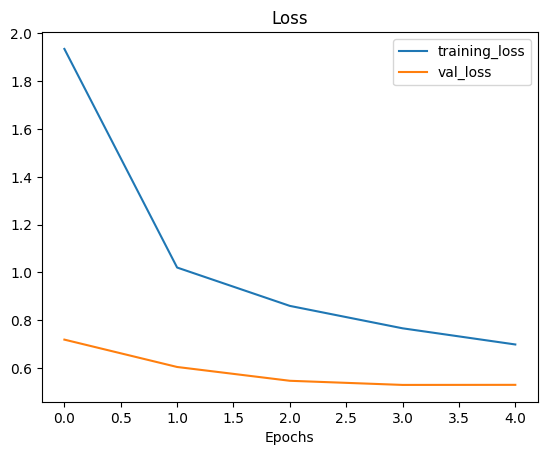

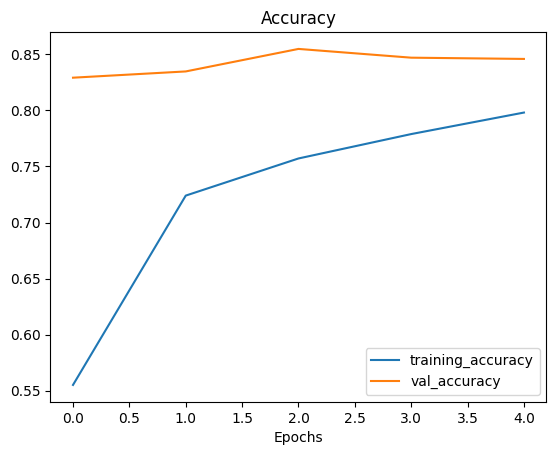

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [18]:
#Evaluation
model.evaluate(test_data)

193/193 [==============================] - 15s 79ms/step - loss: 0.4884 - accuracy: 0.8447


[0.48842284083366394, 0.8446791172027588]

In [19]:
# prediction 
pred_probs = model.predict(test_data, verbose=1)

193/193 [==============================] - 16s 75ms/step


In [20]:
# How many predictions are there?
len(pred_probs)

6155

In [21]:
# What's the shape of our predictions?
pred_probs.shape

(6155, 120)

In [22]:
# How do they look?
pred_probs[:10]

array([[9.2177999e-01, 3.6601898e-05, 2.8196566e-06, ..., 9.3759234e-05,
        1.3532588e-04, 6.3255652e-06],
       [2.8859368e-01, 4.5635188e-06, 7.9118203e-05, ..., 4.5616049e-03,
        9.7618772e-07, 3.5377510e-05],
       [8.9237815e-01, 4.9415266e-05, 2.2956139e-05, ..., 3.3504508e-05,
        7.3619469e-07, 7.5874595e-05],
       ...,
       [9.3379849e-01, 6.9680948e-07, 5.6380617e-07, ..., 4.2794421e-03,
        2.7546580e-06, 9.3884080e-07],
       [3.2570029e-03, 7.8895050e-07, 2.1833202e-06, ..., 2.4643259e-03,
        2.0887232e-05, 1.5849457e-05],
       [2.2826467e-01, 2.1974967e-01, 1.4333255e-04, ..., 1.5986272e-05,
        4.8099686e-05, 1.7373997e-05]], dtype=float32)

In [23]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 120
What prediction probability sample 0 looks like:
 [9.21779990e-01 3.66018976e-05 2.81965663e-06 2.76183550e-06
 1.60545233e-06 2.77791878e-05 4.15112387e-04 5.55722117e-02
 6.45120224e-07 4.60330263e-08 4.56075031e-06 3.06930306e-05
 2.05613037e-06 6.94523692e-07 1.22667257e-06 6.68283917e-07
 4.41353950e-06 3.30927105e-05 7.59140164e-08 2.03805630e-08
 9.44290150e-05 3.35594559e-05 8.03076196e-04 7.61357683e-07
 1.34540727e-07 4.01471607e-06 1.34782155e-07 1.23039126e-06
 2.11129463e-05 4.23898246e-06 1.74334696e-06 1.89028469e-05
 1.51117320e-06 2.20861716e-06 7.67656638e-06 1.46950715e-05
 2.54341376e-05 7.88694138e-07 1.30325816e-06 1.07227372e-07
 4.04437905e-08 1.23066468e-06 1.28592010e-05 1.71940792e-05
 1.41522952e-03 4.02218893e-06 6.49615615e-08 3.47203724e-07
 2.68490635e-06 1.37020791e-07 4.40615895e-06 7.16878858e-08
 1.96096991e-07 3.66980856e-07 5.99147484e-07 1.83820845e-07
 1.67243797e-05 1.04229036e-06 5.11354131e-

In [24]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([  0, 116,   0,   0,   0, 117,   0,   0,   7,  44])

In [30]:
class_names = train_data.class_names

In [37]:
class_names[pred_classes[3]]

'n02085620-Chihuahua'

In [25]:
model.save('my_model.h5')

### Make prediction on Custom Images

In [38]:
# Make function to preprocess our raw data
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 40ms/step


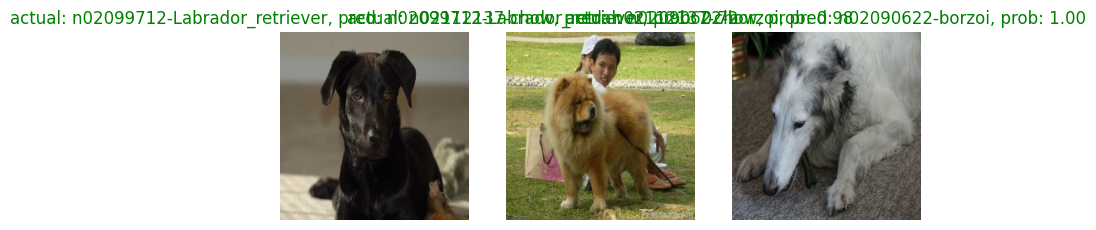

In [42]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 6, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

1/1 [==============================] - 0s 46ms/step


(-0.5, 223.5, 223.5, -0.5)

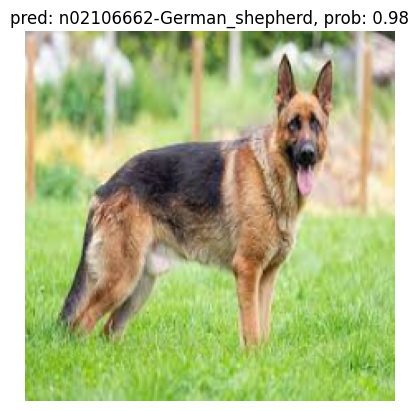

In [44]:
dog_img = "/content/download (1).jpeg"
img = load_and_prep_image(dog_img, scale=False) # load in target image and turn it into tensor
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class label
# Plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.) # imshow() requires float inputs to be normalized
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)

In [51]:
def predict_custom_img(dog_img):
  img = load_and_prep_image(dog_img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)


1/1 [==============================] - 0s 40ms/step


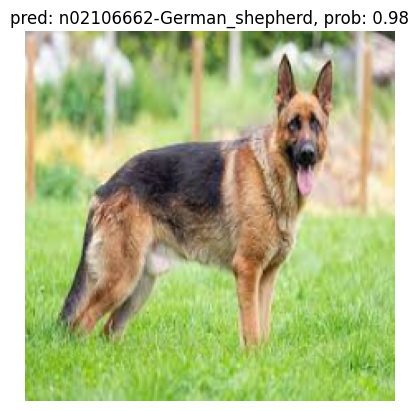

In [46]:
predict_custom_img('/content/download (2).jpeg')

1/1 [==============================] - 0s 30ms/step


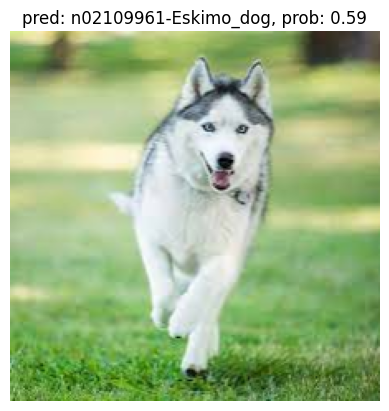

In [52]:
predict_custom_img("/content/prediction/download.jpeg")

1/1 [==============================] - 0s 30ms/step


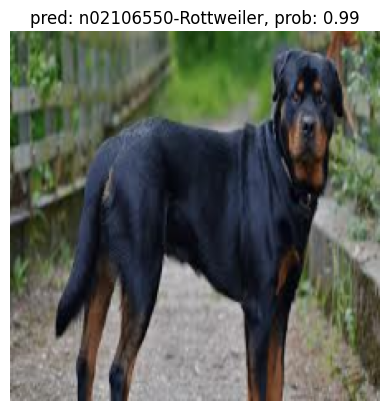

In [53]:
predict_custom_img("/content/prediction/images.jpeg")

1/1 [==============================] - 0s 86ms/step


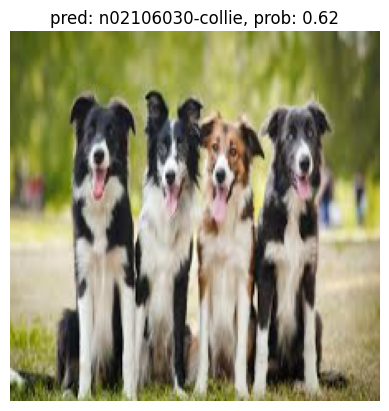

In [55]:
predict_custom_img("/content/prediction/images (1).jpeg")